In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from keras import layers, regularizers
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160  # Image resize dimension
color_img_train = []
color_img_test = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    img = cv2.imread(os.path.join(path, i), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    
    if i < '6000.jpg':
        color_img_train.append(img_to_array(img))  # Add to training set
    else:
        color_img_test.append(img_to_array(img))   # Add to test set

# Convert lists to numpy arrays
color_img_train = np.array(color_img_train)
color_img_test = np.array(color_img_test)

print(f"Training set size: {color_img_train.shape}")
print(f"Test set size: {color_img_test.shape}")


100%|██████████| 7129/7129 [00:48<00:00, 145.98it/s]


Training set size: (5559, 160, 160, 3)
Test set size: (1570, 160, 160, 3)


In [3]:
gray_img_train = []
gray_img_test = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    img = cv2.imread(os.path.join(path, i), 1)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    
    if i < '6000.jpg':
        gray_img_train.append(img_to_array(img))  # Add to training set
    else:
        gray_img_test.append(img_to_array(img))   # Add to test set

# Convert lists to numpy arrays
gray_img_train = np.array(gray_img_train)
gray_img_test = np.array(gray_img_test)

print(f"Training set size (grayscale): {gray_img_train.shape}")
print(f"Test set size (grayscale): {gray_img_test.shape}")

100%|██████████| 7129/7129 [00:49<00:00, 144.82it/s]


Training set size (grayscale): (5559, 160, 160, 3)
Test set size (grayscale): (1570, 160, 160, 3)


In [4]:
gray_img_train = np.array(gray_img_train)
gray_img_test = np.array(gray_img_test)

In [5]:
print(f"Color Training set size: {color_img_train.shape}")
print(f"Color Test set size: {color_img_test.shape}")
print(f"Gray Training set size: {gray_img_train.shape}")
print(f"Gray Test set size: {gray_img_test.shape}")

Color Training set size: (5559, 160, 160, 3)
Color Test set size: (1570, 160, 160, 3)
Gray Training set size: (5559, 160, 160, 3)
Gray Test set size: (1570, 160, 160, 3)


In [6]:
split_index = int(len(gray_img_train) * 0.95)

train_gray_image = gray_img_train[:split_index]
val_gray_image = gray_img_train[split_index:]
train_color_image = color_img_train[:split_index]
val_color_image = color_img_train[split_index:]

# Reshape arrays to the required dimensions
train_g = np.reshape(train_gray_image, (len(train_gray_image), SIZE, SIZE, 3))
train_c = np.reshape(train_color_image, (len(train_color_image), SIZE, SIZE, 3))
val_g = np.reshape(val_gray_image, (len(val_gray_image), SIZE, SIZE, 3))
val_c = np.reshape(val_color_image, (len(val_color_image), SIZE, SIZE, 3))
test_gray_image = np.reshape(gray_img_test, (len(gray_img_test), SIZE, SIZE, 3))
test_color_image = np.reshape(color_img_test, (len(color_img_test), SIZE, SIZE, 3))

# Check shapes to confirm they are aligned
print('Train color image shape:', train_c.shape)
print('Validation color image shape:', val_c.shape)
print('Test color image shape:', test_color_image.shape)

Train color image shape: (5281, 160, 160, 3)
Validation color image shape: (278, 160, 160, 3)
Test color image shape: (1570, 160, 160, 3)


In [7]:
def down(filters, kernel_size, batch_norm):
    def block(x):
        x = layers.Conv2D(filters, kernel_size, strides=2, padding="same",
                          kernel_regularizer=regularizers.l2(0.00000000001))(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x
    return block

def up(filters, kernel_size, batch_norm):
    def block(x):
        x = layers.Conv2DTranspose(filters, kernel_size, strides=2, padding="same",
                                   kernel_regularizer=regularizers.l2(0.00000000001))(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x
    return block

In [8]:
def recolourization_model():
    inputs = layers.Input(shape=(160, 160, 3))

    # Downsampling
    d1 = down(128, (3, 3), False)(inputs)
    d2 = down(128, (3, 3), False)(d1)
    d3 = down(256, (3, 3), True)(d2)
    d4 = down(512, (3, 3), True)(d3)
    d5 = down(512, (3, 3), True)(d4)

    # Upsampling
    u1 = up(512, (3, 3), False)(d5)
    u1 = layers.concatenate([u1, d4])
    u2 = up(256, (3, 3), False)(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(128, (3, 3), False)(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(128, (3, 3), False)(u3)
    u4 = layers.concatenate([u4, d1])

    u5 = up(3, (3, 3), False)(u4)
    u5 = layers.concatenate([u5, inputs])

    # Output layer with sigmoid activation for [0, 1] range
    output = layers.Conv2D(3, (3, 3), strides=1, padding='same', activation='sigmoid',
                           kernel_regularizer=regularizers.l2(0.01))(u5)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [9]:
recolourization_model = recolourization_model()
recolourization_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 80, 80,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │    147,584 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 40, 40,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 20, 20,    │    295,168 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 20,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │  1,180,160 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 512) │  2,359,808 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 5, 5, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 10, 10,    │  2,359,808 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 10, 10,    │          0 │ conv2d_transpose… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ re_lu[0][0],      │
│ (Concatenate)       │ 1024)             │            │ leaky_re_lu_3[0]

 Total params: 9,602,856 (36.63 MB)

 Trainable params: 9,600,296 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [10]:
recolourization_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss='mse', metrics=['mae'])

In [11]:
history = recolourization_model.fit(train_g, train_c, epochs = 105,batch_size = 50,validation_data=(val_g, val_c),verbose = 1)

Epoch 1/105


I0000 00:00:1731071934.140625      94 service.cc:145] XLA service 0x7817c80049c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731071934.140816      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/106 ━━━━━━━━━━━━━━━━━━━━ 25:01 14s/step - loss: 0.1312 - mae: 0.2502

I0000 00:00:1731071944.172903      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 203ms/step - loss: 0.0964 - mae: 0.1940 - val_loss: 0.0848 - val_mae: 0.2185
Epoch 2/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0543 - mae: 0.1483 - val_loss: 0.0469 - val_mae: 0.1598
Epoch 3/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0200 - mae: 0.0818 - val_loss: 0.0181 - val_mae: 0.0946
Epoch 4/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0119 - mae: 0.0710 - val_loss: 0.0169 - val_mae: 0.0955
Epoch 5/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0095 - mae: 0.0656 - val_loss: 0.0125 - val_mae: 0.0807
Epoch 6/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0088 - mae: 0.0641 - val_loss: 0.0170 - val_mae: 0.0988
Epoch 7/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0080 - mae: 0.0613 - val_loss: 0.0169 - val_mae: 0.1001
Epoch 8/105
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0077 - mae: 0.0604 - val_loss: 0.0089 - val_mae: 0.0675
Epoch 9/105
106/106 ━━━━━━━━━━━━━━━━

In [12]:
recolourization_model.save("/kaggle/working/recolorization_model.keras")

In [13]:
predicted_color = recolourization_model.predict(test_gray_image)

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


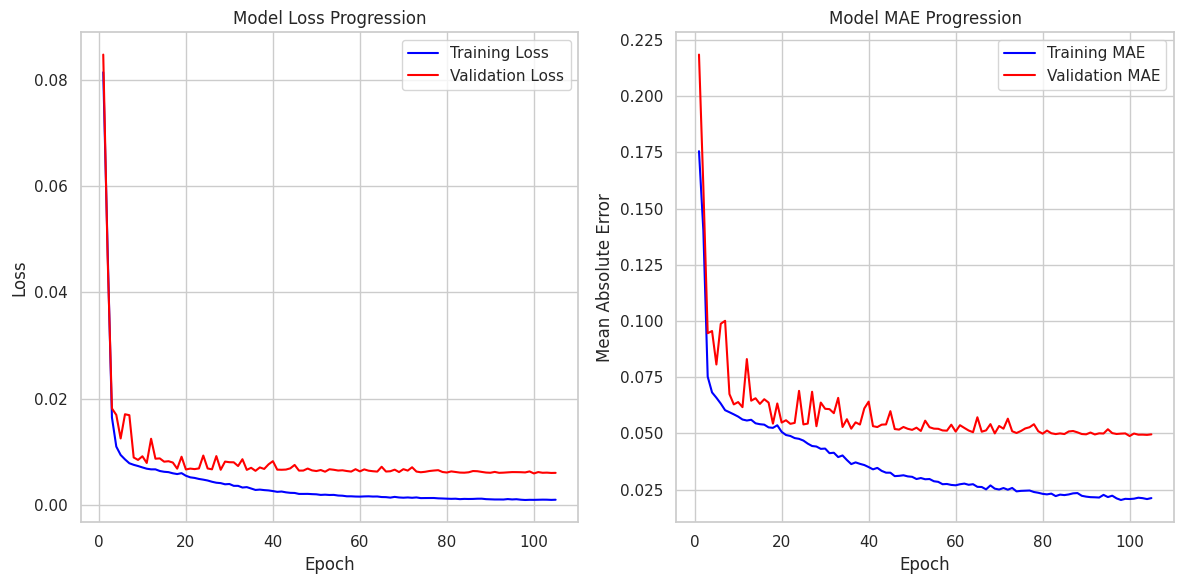

In [14]:
# Extract the loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)
sns.set(style="whitegrid")

# Plot loss (training vs validation)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a 1x2 grid, first subplot for loss
sns.lineplot(x=epochs, y=train_loss, label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', color='red')
plt.title('Model Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot mean absolute error (mae) (training vs validation)
plt.subplot(1, 2, 2)  # Second subplot for mae
sns.lineplot(x=epochs, y=train_mae, label='Training MAE', color='blue')
sns.lineplot(x=epochs, y=val_mae, label='Validation MAE', color='red')
plt.title('Model MAE Progression')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

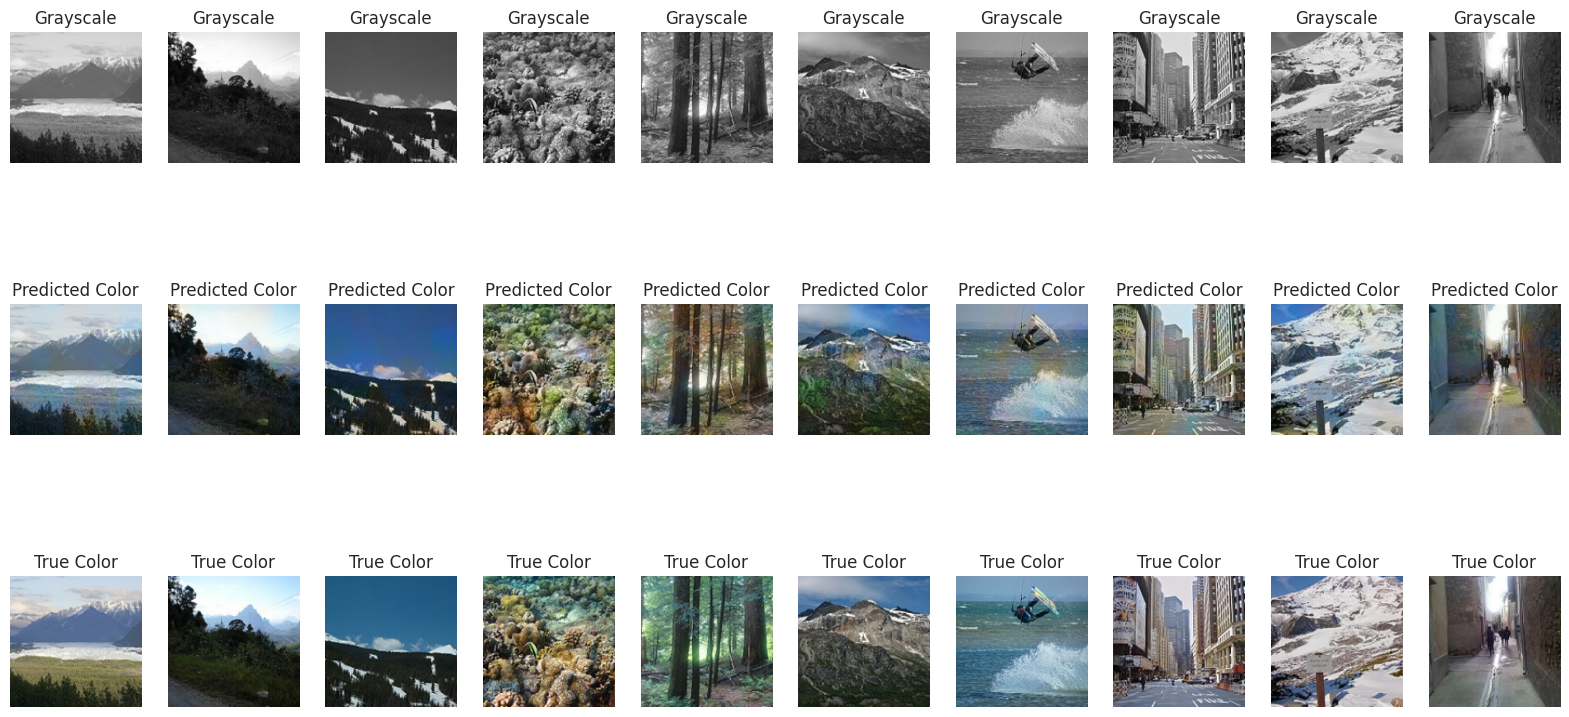

In [15]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 10))
for i in range(n):
    # Grayscale input images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_gray_image[i], cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    # Predicted color images
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(predicted_color[i])
    plt.title("Predicted Color")
    plt.axis('off')

    # Ground truth color images
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(test_color_image[i])
    plt.title("True Color")
    plt.axis('off')

plt.show()

In [16]:
psnr_value = psnr(test_color_image[0], predicted_color[0], data_range=1.0)
ssim_value = ssim(test_color_image[0], predicted_color[0], multichannel=True, win_size=3, channel_axis=-1, data_range=1.0)

print(f"PSNR: {psnr_value}, SSIM: {ssim_value}")

PSNR: 22.809714345038735, SSIM: 0.9491534233093262


In [17]:
recolorization_model = tf.keras.models.load_model("/kaggle/working/recolorization_model.keras", compile=False)
SIZE = 160
def colorize_image(grayscale_img):
    # Resize and normalize the grayscale image to match the model's input format
    img = cv2.resize(grayscale_img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0  # Normalize
    img = np.stack((img, img, img), axis=-1)  # Convert grayscale to 3-channel RGB format
    img = np.expand_dims(img, axis=0)  # Add batch dimension for the model

    # Predict the colorized version using the model
    colorized_img = recolorization_model.predict(img)
    colorized_img = colorized_img[0]  # Remove batch dimension
    colorized_img = np.clip(colorized_img, 0, 1)  # Clip to valid pixel range

    # Convert colorized image to 0-255 scale for visualization
    colorized_img = (colorized_img * 255).astype(np.uint8)
    return colorized_img

In [ ]:
import gradio as gr 
gr_interface = gr.Interface(
    fn=colorize_image,
    inputs=gr.Image(image_mode='L', label="Upload a grayscale image"),
    outputs=gr.Image(label="Colorized Image"),
    title="Image Recolorization",
    description="Upload a grayscale image to see it colorized by the trained model."
)

# Launch the Gradio app
gr_interface.launch()

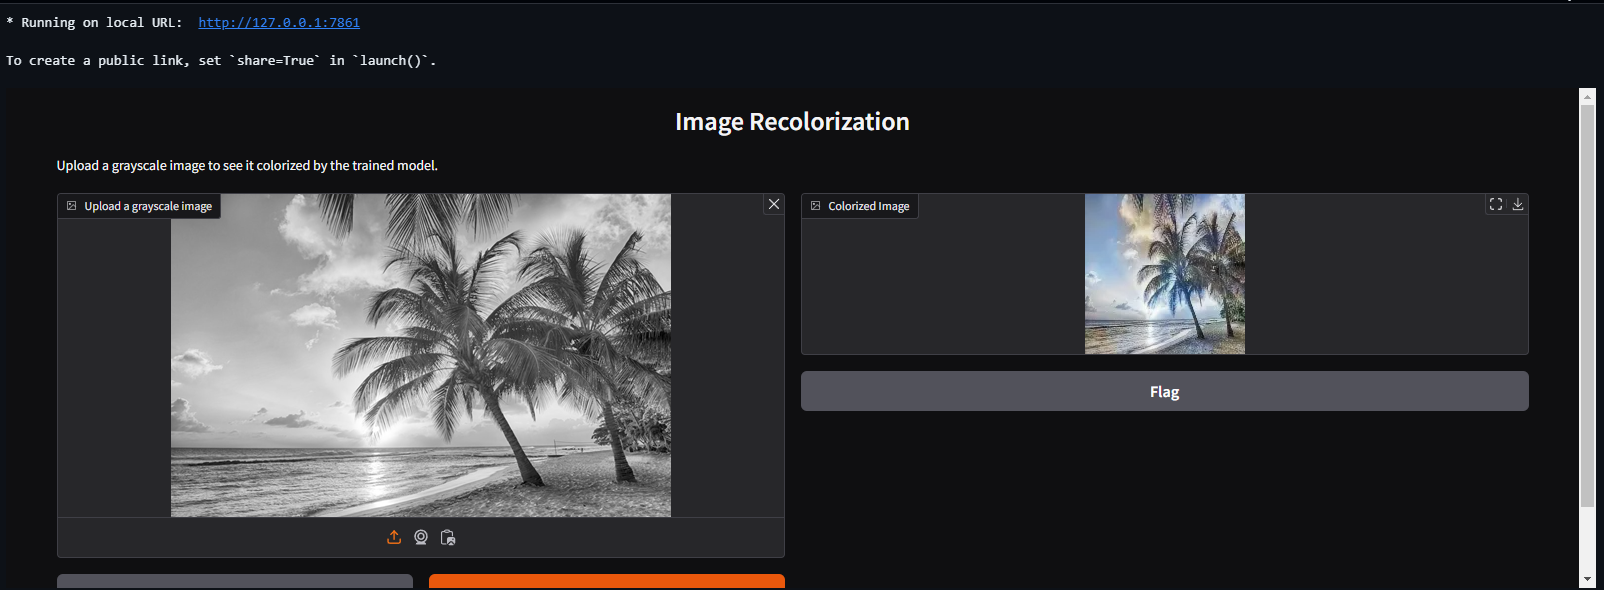